In [106]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import SpatialDropout1D
from keras.preprocessing import text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.utils import pad_sequences
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\Loh Dai
[nltk_data]     Jiu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
df = pd.read_csv("politifact_data.csv")
print(df.shape)
df.drop_duplicates(subset = ['claim'], keep = 'last', inplace = True)


(25923, 12)


In [77]:
df['claim'] = df['claim'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x)).apply(lambda x: x.replace("“", "")).apply(lambda x: x.replace("”", ""))

#Remove stopwords
stop = set(stopwords.words("english"))
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)
df['claim'] = df['claim'].apply(lambda x: remove_stopwords(x))
df['claim']

0              ron johnson came favor federal abortion ban
2           blake masters wants pass national ban abortion
3        brian kemp wants investigate punish women misc...
5        overturning roe v wade unconstitutional action...
6        way shape form access contraception limited ri...
                               ...                        
25918    100 days since passage economic stimulus saved...
25919    employee free choice act mandates elimination ...
25920    state senator illinois obama made sure women g...
25921    illinois senate barack obama passed legislatio...
25922    hillary clinton willing workers wages garnishe...
Name: claim, Length: 16733, dtype: object

In [78]:
x_train, x_test, y_train, y_test = train_test_split(df['claim'], df['accuracy'], random_state = 42, test_size = 0.2)

In [79]:
x_train.shape

(13386,)

In [80]:
def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

In [81]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(x_train)
x_train_tfv =  tfv.transform(x_train) 
x_test_tfv = tfv.transform(x_test)

In [82]:
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
}
lr = LogisticRegression(max_iter=10000, solver='liblinear')
lr_clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
lr_clf.fit(x_train_tfv, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

              precision    recall  f1-score   support

           0       0.74      0.93      0.83      2399
           1       0.51      0.17      0.26       948

    accuracy                           0.72      3347
   macro avg       0.62      0.55      0.54      3347
weighted avg       0.67      0.72      0.66      3347



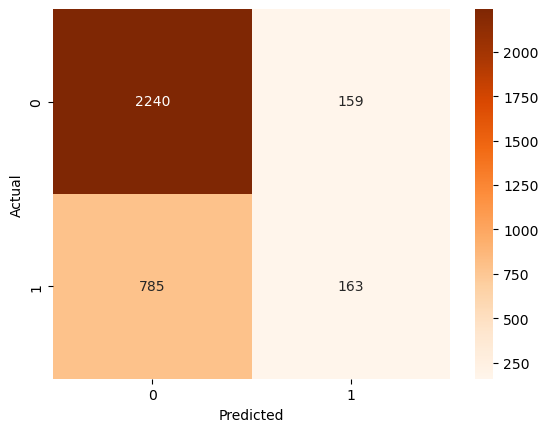

In [83]:
score_model(lr_clf, x_test_tfv, y_test)

In [84]:
print("Best combination of hyperparams:\n", lr_clf.best_params_, "\n")
print("Best mean_test_score score:\n", lr_clf.best_score_, "\n")

Best combination of hyperparams:
 {'C': 1.0, 'penalty': 'l2'} 

Best mean_test_score score:
 0.7221711314357926 



              precision    recall  f1-score   support

           0       0.73      0.97      0.84      2399
           1       0.59      0.11      0.18       948

    accuracy                           0.73      3347
   macro avg       0.66      0.54      0.51      3347
weighted avg       0.69      0.73      0.65      3347



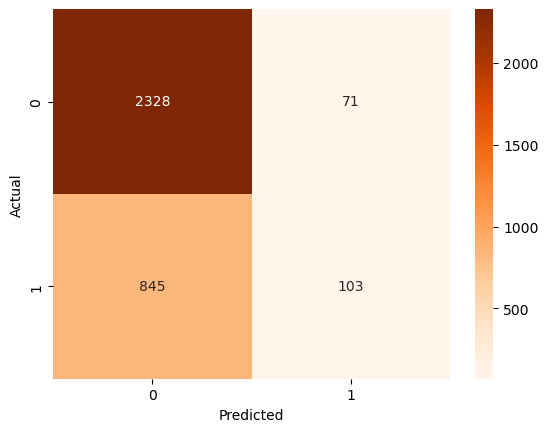

In [85]:
nb_clf = MultinomialNB()
nb_clf.fit(x_train_tfv, y_train)
score_model(nb_clf, x_test_tfv, y_test)

              precision    recall  f1-score   support

           0       0.73      0.97      0.83      2399
           1       0.58      0.12      0.19       948

    accuracy                           0.73      3347
   macro avg       0.66      0.54      0.51      3347
weighted avg       0.69      0.73      0.65      3347



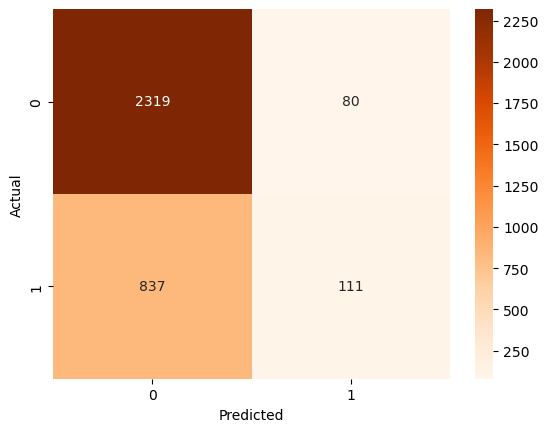

In [86]:
svc_clf = SVC()
svc_clf.fit(x_train_tfv, y_train)
score_model(svc_clf, x_test_tfv, y_test)

In [104]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid']}

gd=GridSearchCV(estimator=SVC(),param_grid=param_grid,verbose=True)

gd.fit(x_train_tfv, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
0.7209772735578686
SVC(C=1, gamma=1)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      2399
           1       0.58      0.12      0.19       948

    accuracy                           0.73      3347
   macro avg       0.66      0.54      0.51      3347
weighted avg       0.69      0.73      0.65      3347

0.7209772735578686
SVC(C=1, gamma=1)


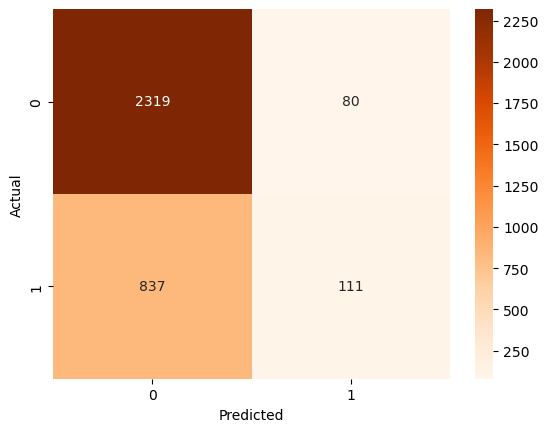

In [108]:
score_model(gd, x_test_tfv, y_test)
print(gd.best_score_)
print(gd.best_estimator_)

[19:46:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      2399
           1       0.54      0.16      0.24       948

    accuracy                           0.72      3347
   macro avg       0.64      0.55      0.54      3347
weighted avg       0.68      0.72      0.66      3347



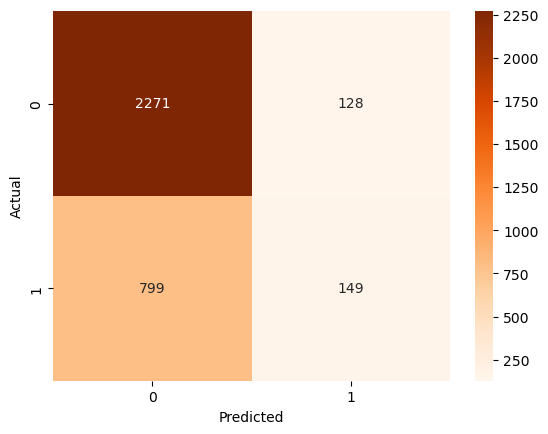

In [88]:
xg_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, use_label_encoder=False)
xg_clf.fit(x_train_tfv, y_train)
score_model(xg_clf, x_test_tfv, y_test)

In [137]:
dnn_model = Sequential()

dnn_model.add(Dense(64, input_dim=11296, activation='relu'))
dnn_model.add(Dropout(0.2))

dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dropout(0.3))

dnn_model.add(Dense(1))
dnn_model.add(Activation('sigmoid'))

# compile the model
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [134]:
dnn_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                723008    
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
 activation_23 (Activation)  (None, 1)                 0         
                                                                 
Total params: 727,233
Trainable params: 727,233
Non-t

In [138]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
dnn = dnn_model.fit(x_train_tfv.toarray(), y=y_train, batch_size=512, epochs=100, verbose=1, validation_data=(x_test_tfv.toarray(), y_test), callbacks=[earlystop])

Epoch 1/100
27/27 [==============================] - 2s 45ms/step - loss: 0.6370 - accuracy: 0.7142 - val_loss: 0.5818 - val_accuracy: 0.7168
Epoch 2/100
27/27 [==============================] - 1s 23ms/step - loss: 0.5542 - accuracy: 0.7152 - val_loss: 0.5570 - val_accuracy: 0.7168
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 0.4937 - accuracy: 0.7152 - val_loss: 0.5458 - val_accuracy: 0.7174
Epoch 4/100
27/27 [==============================] - 1s 20ms/step - loss: 0.4302 - accuracy: 0.7671 - val_loss: 0.5583 - val_accuracy: 0.7192
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 0.3630 - accuracy: 0.8510 - val_loss: 0.6062 - val_accuracy: 0.7018
Epoch 6/100
27/27 [==============================] - 0s 18ms/step - loss: 0.2946 - accuracy: 0.8948 - val_loss: 0.6815 - val_accuracy: 0.6923


In [89]:
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(x_train)
x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)

# zero pad the sequences
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

word_index = token.word_index

In [91]:
#Download from https://www.kaggle.com/datasets/takuok/glove840b300dtxt/code
embeddings_index = {}
f = open('glove.840B.300d.txt', encoding ="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
    embeddings_index[word] = coefs
f.close()

2196017it [03:00, 12159.77it/s]


In [92]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 16571/16571 [00:00<00:00, 37866.71it/s]


In [100]:
lstm_model = Sequential()
lstm_model.add(tf.keras.layers.Embedding(16572,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences = True, activation='tanh'))
lstm_model.add(tf.keras.layers.GlobalMaxPooling1D())
lstm_model.add(Dense(10))

lstm_model.add(Dense(1))
lstm_model.add(Activation('sigmoid'))
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics = ['accuracy'])

In [95]:
lstm_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 70, 300)           4971600   
                                                                 
 spatial_dropout1d_10 (Spati  (None, 70, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_9 (LSTM)               (None, 70, 64)            93440     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
 activation_11 (Activation)  (None, 1)               

In [103]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
lstm = lstm_model.fit(x_train_pad, y=y_train, batch_size=512, epochs=100, verbose=1, validation_data=(x_test_pad, y_test), callbacks=[earlystop])

Epoch 1/100
27/27 [==============================] - 19s 706ms/step - loss: 0.4921 - accuracy: 0.7571 - val_loss: 0.5370 - val_accuracy: 0.7144
Epoch 2/100
27/27 [==============================] - 19s 693ms/step - loss: 0.4893 - accuracy: 0.7618 - val_loss: 0.5350 - val_accuracy: 0.7200
Epoch 3/100
27/27 [==============================] - 19s 712ms/step - loss: 0.4840 - accuracy: 0.7616 - val_loss: 0.5351 - val_accuracy: 0.7197
Epoch 4/100
27/27 [==============================] - 17s 621ms/step - loss: 0.4800 - accuracy: 0.7651 - val_loss: 0.5372 - val_accuracy: 0.7177
Epoch 5/100
27/27 [==============================] - 16s 600ms/step - loss: 0.4790 - accuracy: 0.7646 - val_loss: 0.5339 - val_accuracy: 0.7293
Epoch 6/100
27/27 [==============================] - 17s 646ms/step - loss: 0.4721 - accuracy: 0.7687 - val_loss: 0.5455 - val_accuracy: 0.7066
Epoch 7/100
27/27 [==============================] - 19s 721ms/step - loss: 0.4668 - accuracy: 0.7719 - val_loss: 0.5410 - val_accuracy:

In [99]:
gru_model = Sequential()
gru_model.add(tf.keras.layers.Embedding(16572,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
gru_model.add(SpatialDropout1D(0.3))
gru_model.add(tf.keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
gru_model.add(Dense(10))

gru_model.add(Dense(1))
gru_model.add(Activation('sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
gru = gru_model.fit(x_train_pad, y=y_train, batch_size=512, epochs=100, 
          verbose=1, validation_data=(x_test_pad, y_test), callbacks=[earlystop])

Epoch 1/100
27/27 [==============================] - 16s 434ms/step - loss: 0.6527 - accuracy: 0.7097 - val_loss: 0.6124 - val_accuracy: 0.7163
Epoch 2/100
27/27 [==============================] - 12s 456ms/step - loss: 0.6008 - accuracy: 0.7136 - val_loss: 0.5943 - val_accuracy: 0.7170
Epoch 3/100
27/27 [==============================] - 12s 446ms/step - loss: 0.5955 - accuracy: 0.7151 - val_loss: 0.5936 - val_accuracy: 0.7168
Epoch 4/100
27/27 [==============================] - 12s 434ms/step - loss: 0.5951 - accuracy: 0.7151 - val_loss: 0.5928 - val_accuracy: 0.7170
Epoch 5/100
27/27 [==============================] - 12s 425ms/step - loss: 0.5945 - accuracy: 0.7151 - val_loss: 0.5925 - val_accuracy: 0.7170
Epoch 6/100
27/27 [==============================] - 12s 427ms/step - loss: 0.5940 - accuracy: 0.7155 - val_loss: 0.5922 - val_accuracy: 0.7169
Epoch 7/100
27/27 [==============================] - 12s 428ms/step - loss: 0.5944 - accuracy: 0.7153 - val_loss: 0.5920 - val_accuracy:

In [102]:
gru_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000001DBB17247C0>>